In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
import scipy.stats as st
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Генерация признаков

## Случайные выбросы

In [2]:
def plot(y, out_target, colors=None):
    if colors is None:
        colors = list(np.where(out_target, 'red', 'blue'))
    plt.figure(figsize=(20, 6))
    plt.scatter(range(len(y)), y, color=colors)
    
    
def color_points(row, target, b_lower, b_upper):
    if type(row) == pd.Series:
        row = row.values
    if type(target) == pd.Series:
        target = target.values
    target = np.bool_(target)
    condlist = [target & ((row < b_lower) | (row > b_upper)),
                target & ((b_lower<=row) | (row<=b_upper)),
                ~target & ((row < b_lower) | (row > b_upper))]
    choice_list = ['green', 'red', 'magenta']
    return np.select(condlist, choice_list, default='blue')


def color_points_binary(y_true, y_pred):
    y_true = np.bool_(y_true)
    condlist = [y_true & y_pred,
                y_true & ~y_pred,
                ~y_true & y_pred]
    choice_list = ['green', 'red', 'magenta']
    return np.select(condlist, choice_list, default='blue')


def gen_outliers(mean, scale=7, out_ratio=0.02, size=10000, seed=17):
    np.random.seed(seed)
    
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio])
    out_value = np.random.uniform(1.3, 2, size=size)
    out_sign = np.random.choice([True, False], size)
    row = np.where(out_target&out_sign, row*out_value, row)
    row = np.where(out_target&(~out_sign), row/out_value, row)
    return row, out_target

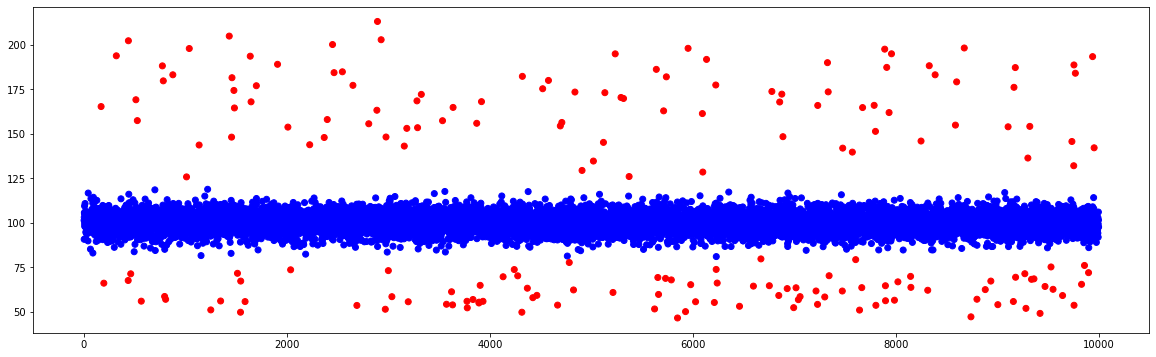

In [3]:
row, out_target = gen_outliers(100, 5)
plot(row, out_target)

## Случайные выбросы по несколько точек c разными значениями

In [4]:
def gen_outliers_in_row_random(mean, scale=5, n_points=5, out_ratio=0.015, size=10000, seed=17):
    np.random.seed(seed)
    
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = pd.Series(np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio]))
    out_value = pd.Series(np.random.uniform(1.4, 3, size=size))
    out_sign = pd.Series(np.random.choice([True, False], size))
    
    out_target_df = pd.DataFrame()
    for i in range(n_points):
        out_target_df[f'{i}'] = out_target.shift(i)
        row = np.where(out_target.shift(i)&out_sign.shift(i), row*out_value.shift(i), row)
        row = np.where(out_target.shift(i)&(~out_sign.shift(i).fillna(True)), row/out_value.shift(i), row)
    out_target = out_target_df.any(axis=1)
    return row, out_target.values

In [5]:
row, out_target = gen_outliers_in_row_random(100, 5)

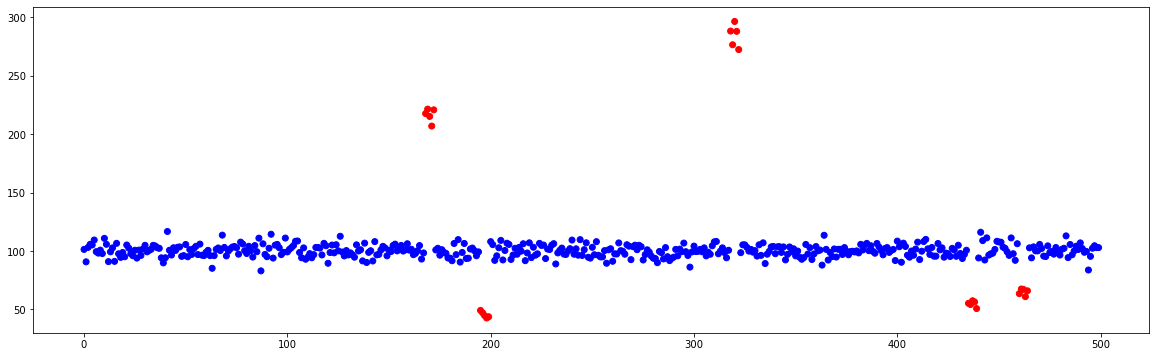

In [6]:
plot(row[0: 500], out_target[0: 500])

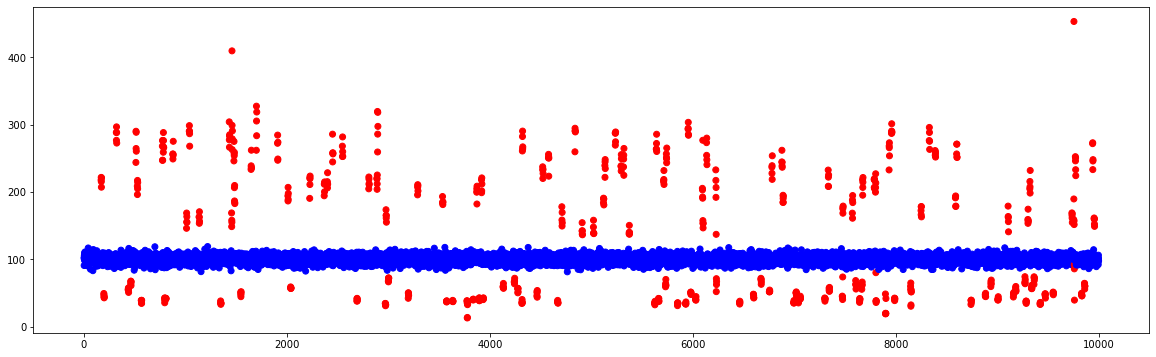

In [7]:
plot(row, out_target)

## Случайные выбросы по несколько точек c одинаковыми значениями

In [8]:
def gen_outliers_in_row_equal(mean, scale=7, n_points=10, out_ratio=0.01, size=10000, seed=17):
    np.random.seed(seed)
    row = np.random.normal(loc=mean, scale=scale, size=size)
    
    out_target = np.random.choice([True, False], size, p=[out_ratio, 1-out_ratio])
    out_value = np.random.uniform(1.3, 2, size=size)
    out_sign = np.random.choice([True, False], size)
    row = np.where(out_target&out_sign, row*out_value, row)
    row = np.where(out_target&(~out_sign), row/out_value, row)
    row = pd.Series(row)
    out_target = pd.Series(out_target)
    
    for i in range(n_points+1):
        row = pd.Series(np.where(out_target.shift(i), row.shift(i), row))
    out_target = out_target.replace(False, np.nan).fillna(method='ffill', limit=n_points).fillna(False)
    return row.values, out_target.values

In [9]:
row, out_target = gen_outliers_in_row_equal(100, 3, seed=5)

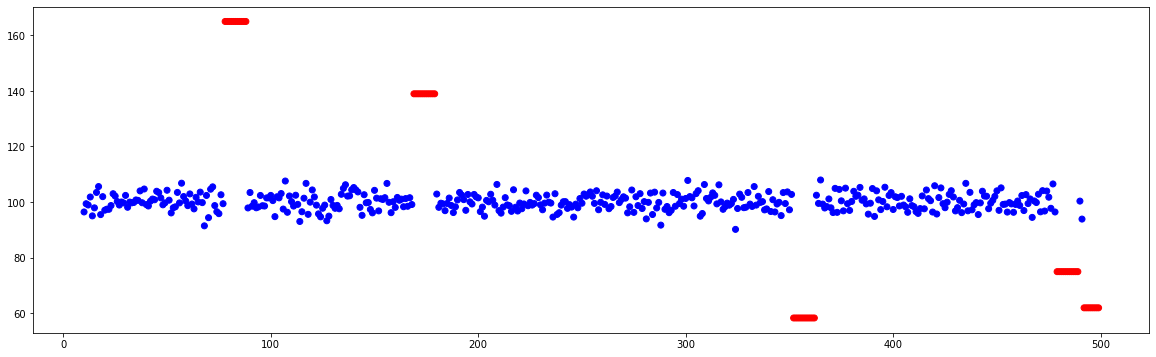

In [10]:
plot(row[0: 500], out_target[0: 500])

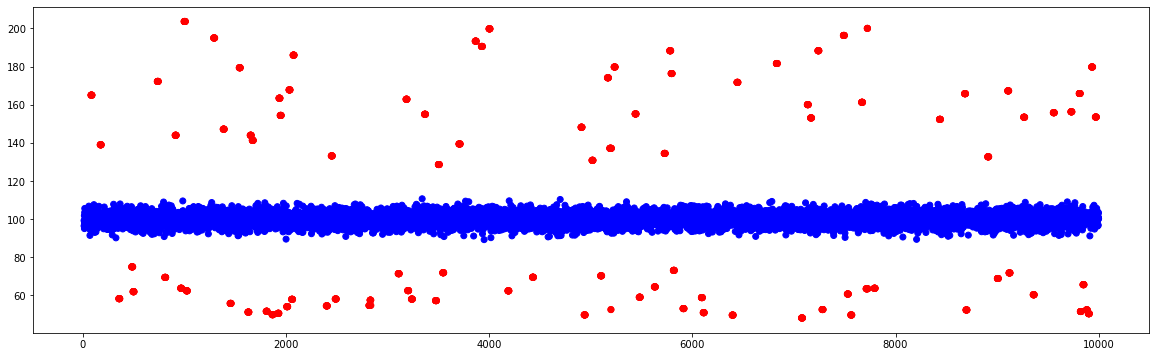

In [11]:
plot(row, out_target)

## Плавное изменение значений (без выбросов)

In [12]:
def gen_sin_row(mean, scale, size=10000, seed=17):
    np.random.seed(17)
    row = np.sin(np.arange(size)/ 300)*5 + np.random.normal(mean, scale, size)
    out_target = np.array([False]*size)
    return row, out_target

In [13]:
row, out_target = gen_sin_row(100, 1)

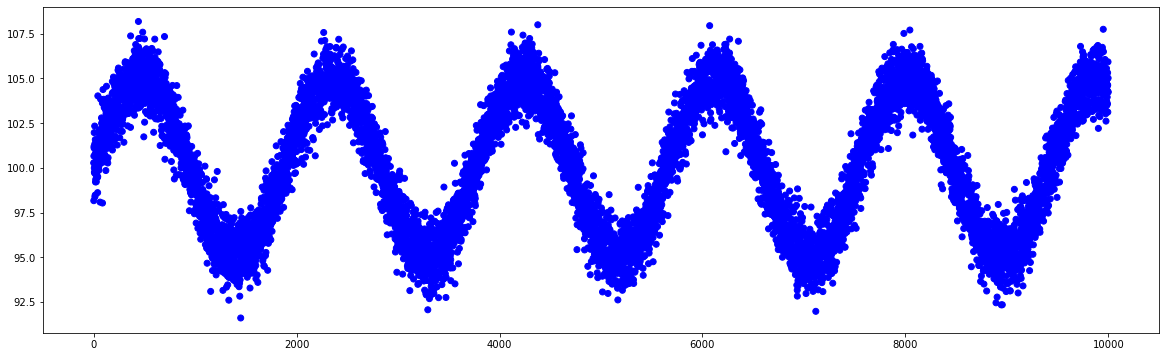

In [14]:
plot(row, out_target)

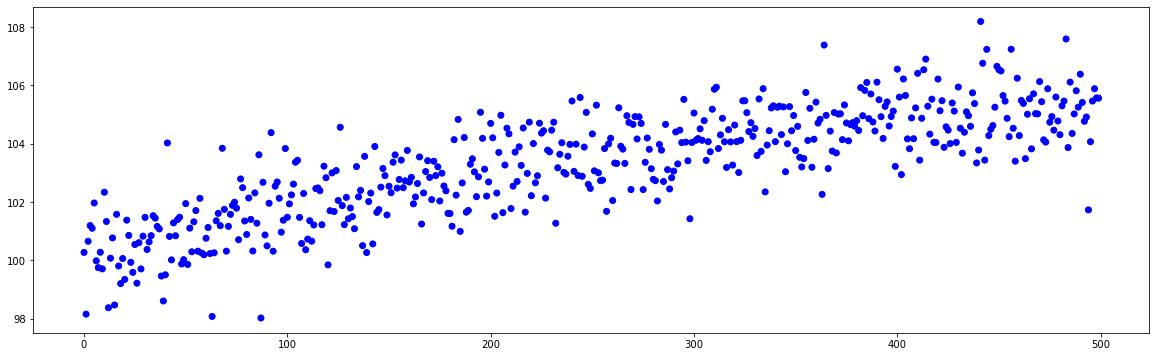

In [15]:
plot(row[:500], out_target[:500])

## Изменение значений ступенями с резким скачком

 Выбросом считается только первая точка после скачка

In [16]:
def gen_step_change(n_steps=25, scale=5, min_value=0, max_value=500, size=10000, seed=17):
    assert size % n_steps == 0, "Длина ряда должна делиться на количество ступеней без остатка"
    n_points = size // n_steps
    res = []
    out_target = []
    
    mean = None
    for step in range(n_steps):
        while True:
            # Make sure that the gap is exists
            new_mean = np.random.uniform(min_value, max_value)
            if mean is None or abs(new_mean - mean) > 50:
                mean = new_mean
                break
        row = np.random.normal(mean, scale, size=n_points)
        res.append(row)
        if step != 0:
            out_target.append([True] + [False]*(n_points-1))
        else:
            out_target.append([False] * n_points)
            
    row = np.concatenate(res)
    out_target = np.concatenate(out_target)
    return row, out_target

In [17]:
row, out_target = gen_step_change()

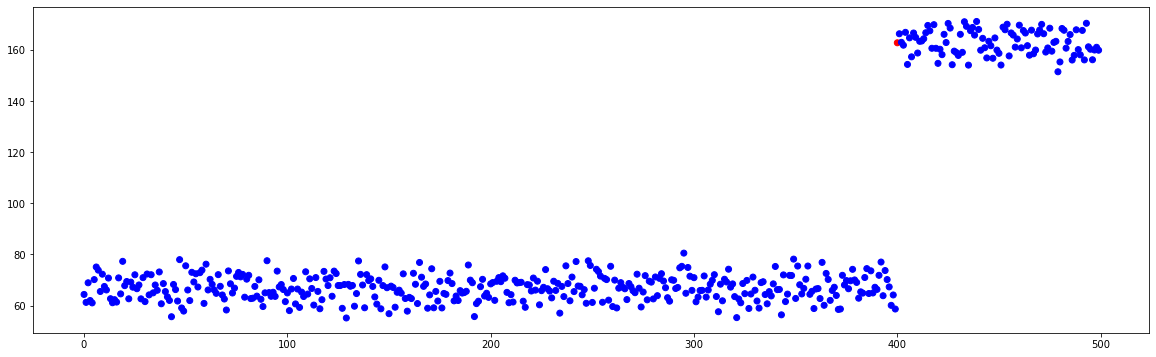

In [18]:
plot(row[:500], out_target[:500])

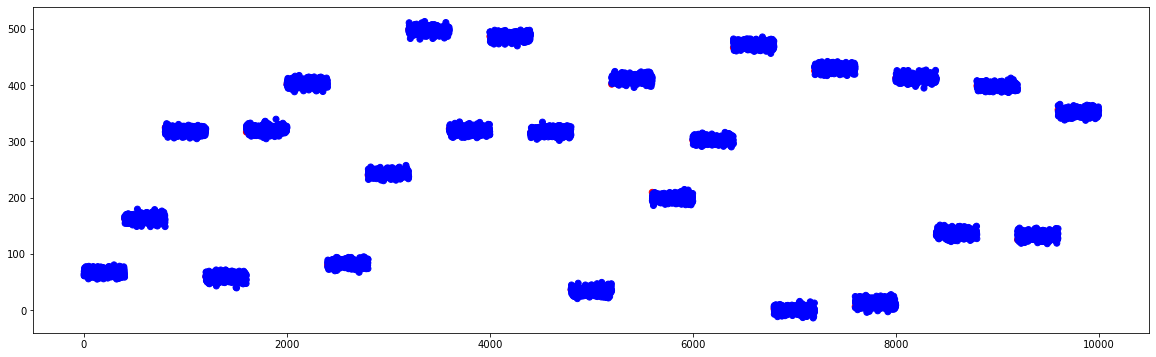

In [19]:
plot(row, out_target)

# Фильтрация выбросов

## Фильтрация по доверительному интервалу

In [20]:
df_outliers = pd.DataFrame()
df_outliers[['row1', 'out_target1']] = np.stack(gen_outliers(100, 5), axis=1)
df_outliers[['row2', 'out_target2']] = np.stack(gen_outliers_in_row_random(100, 5), axis=1)
df_outliers[['row3', 'out_target3']] = np.stack(gen_outliers_in_row_equal(100, 3, seed=5), axis=1)
df_outliers[['row4', 'out_target4']] = np.stack(gen_sin_row(100, 1), axis=1)
df_outliers[['row5', 'out_target5']] = np.stack(gen_step_change(), axis=1)

In [21]:
df_outliers

,row1,out_target1,row2,out_target2,row3,out_target3,row4,out_target4,row5,out_target5
0,101.381329,0.0,101.381329,0.0,NaN,0.0,100.276266,0.0,64.355094,0.0
1,90.726860,0.0,90.726860,0.0,NaN,0.0,98.162039,0.0,61.244417,0.0
2,103.119506,0.0,103.119506,0.0,NaN,0.0,100.657234,0.0,68.908623,0.0
3,105.726556,0.0,105.726556,0.0,NaN,0.0,101.195310,0.0,61.972574,0.0
4,105.185952,0.0,105.185952,0.0,NaN,0.0,101.103855,0.0,61.043689,0.0
...,...,...,...,...,...,...,...,...,...,...
9995,91.942390,0.0,91.942390,0.0,99.896542,0.0,103.118781,0.0,351.770165,0.0
9996,97.692936,0.0,97.692936,0.0,96.749110,0.0,104.263464,0.0,357.780745,0.0
9997,106.054547,0.0,106.054547,0.0,103.283068,0.0,105.930307,0.0,361.172758,0.0
9998,101.541153,0.0,101.541153,0.0,100.893167,0.0,105.022098,0.0,346.588439,0.0


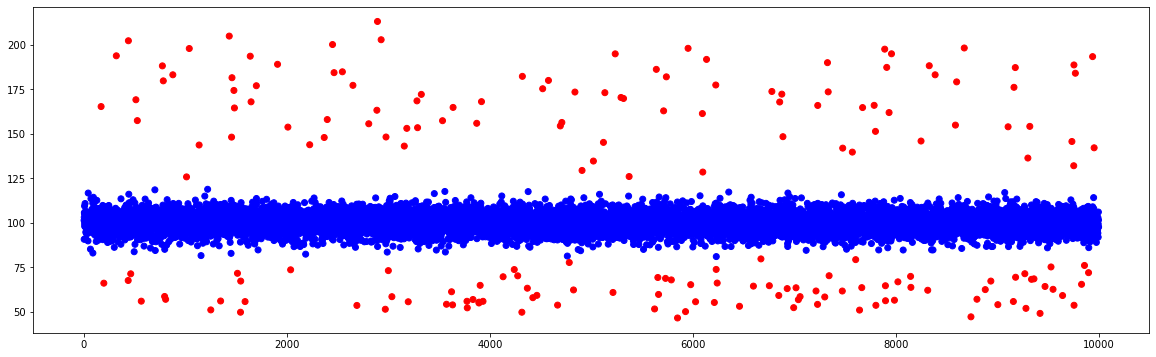

In [22]:
plot(df_outliers['row1'], df_outliers['out_target1'])

In [23]:
def get_confidence_borders(row, window=100, p=0.95):
    z = st.norm.ppf(p)
    x = row.copy()
    x_roll = x.rolling(window, min_periods=30)
    ma = x_roll.mean().fillna(0)
    sigma = x_roll.std().fillna(0)
    b_lower = ma - sigma * z
    b_upper = ma + sigma * z
    y_pred = (x < b_lower) | (x > b_upper)
    return ma, b_lower, b_upper, y_pred
   

def plot_borders(row, target, ma, b_lower, b_upper, colors=None, start=None, stop=None):
    plt.figure(figsize=(20, 6))
    plot(row, target, colors=colors)
    plt.fill_between(range(ma.shape[0]), b_lower, b_upper, color='orange', alpha=0.6)
    if start is not None and stop is not None:
        plt.xlim(start, stop)
        
        
def compute_metrics(y_true, y_pred):
    print('precision', precision_score(y_true, y_pred))
    print('recall', recall_score(y_true, y_pred))
    print('f1', f1_score(y_true, y_pred))
    print('=' * 80)

### Фильтрация на абсолютных значениях

<Figure size 1440x432 with 0 Axes>

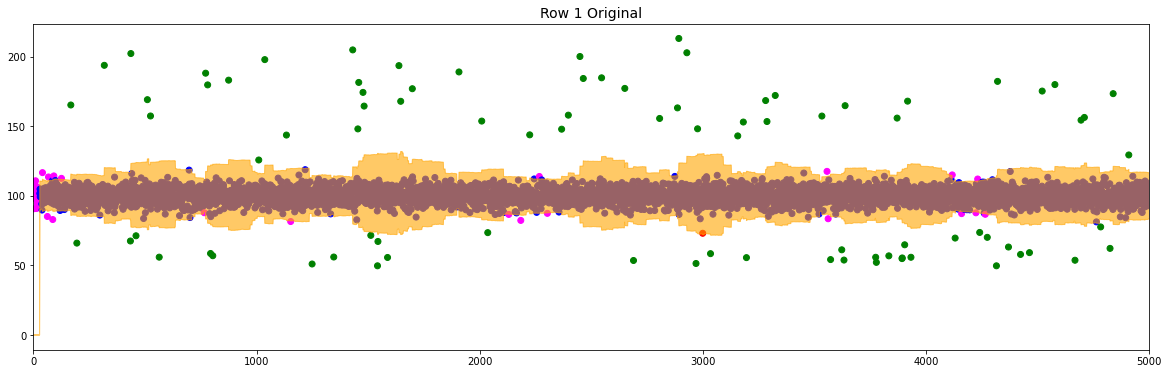

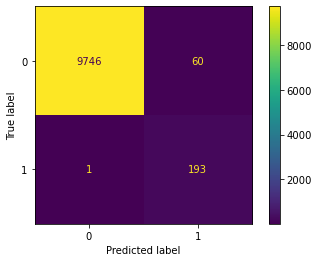

precision 0.7628458498023716
recall 0.9948453608247423
f1 0.8635346756152126


<Figure size 1440x432 with 0 Axes>

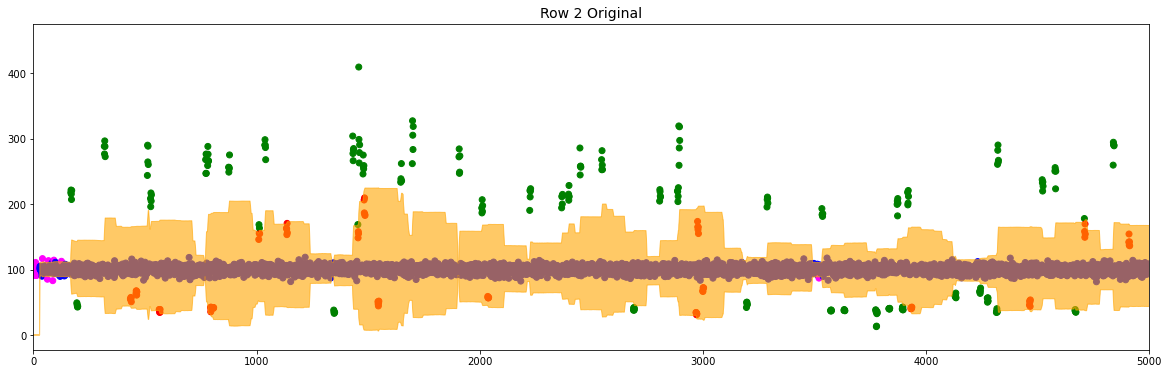

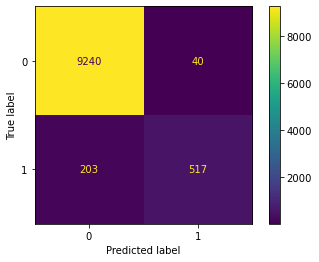

precision 0.9281867145421903
recall 0.7180555555555556
f1 0.8097102584181675


<Figure size 1440x432 with 0 Axes>

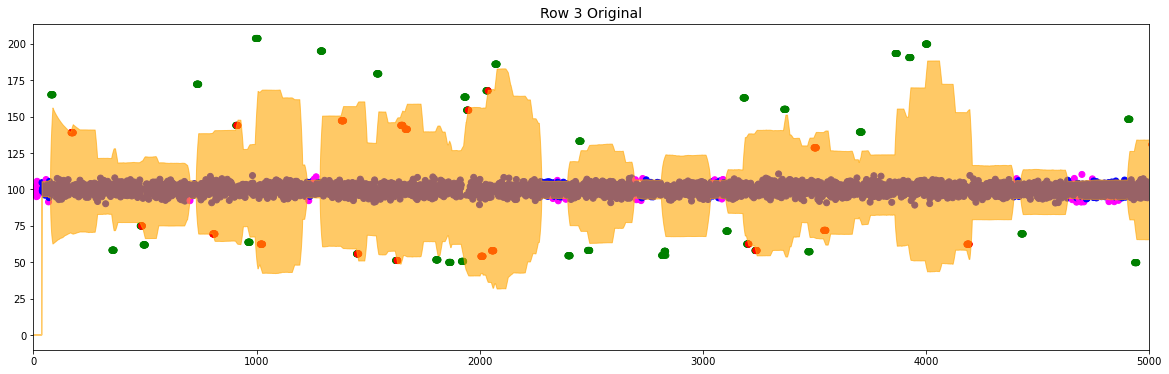

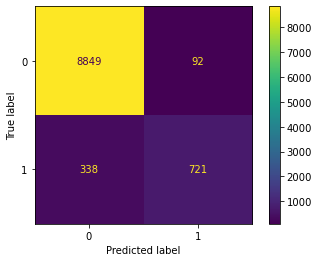

precision 0.8868388683886839
recall 0.6808309726156752
f1 0.7702991452991452


<Figure size 1440x432 with 0 Axes>

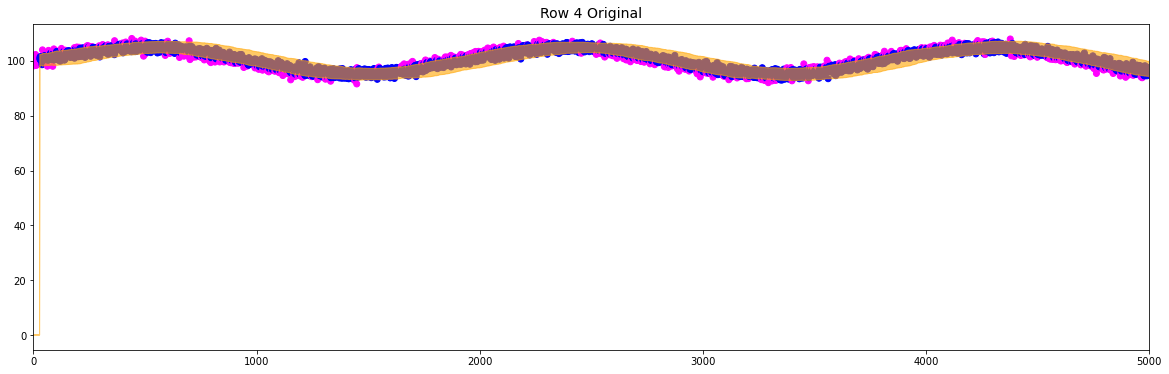

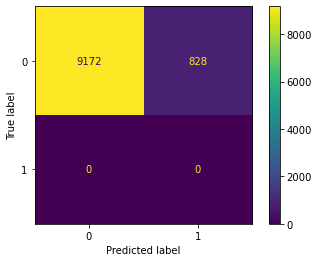

precision 0.0
recall 0.0
f1 0.0


D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x432 with 0 Axes>

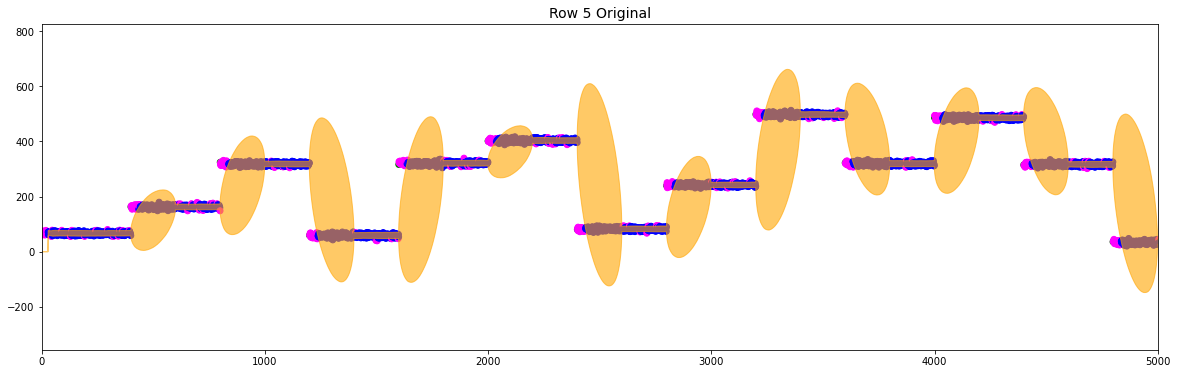

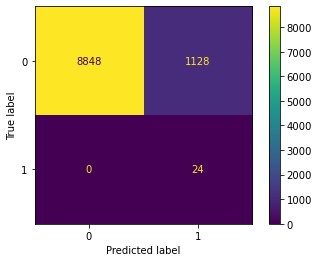

precision 0.020833333333333332
recall 1.0
f1 0.04081632653061225


In [24]:
for i in range(1, 6):
    ma, b_lower, b_upper, y_pred = get_confidence_borders(df_outliers[f'row{i}'], window=200, p=0.98)
    colors = color_points(df_outliers[f'row{i}'].values, df_outliers[f'out_target{i}'].values, b_lower, b_upper)   
    plot_borders(df_outliers[f'row{i}'], df_outliers[f'out_target{i}'], 
                 ma, b_lower, b_upper, colors, start=0, stop=5000)
    plt.title(f'Row {i} Original', size=14)
    ConfusionMatrixDisplay(confusion_matrix(df_outliers[f'out_target{i}'], y_pred)).plot()
    plt.show()
    compute_metrics(df_outliers[f'out_target{i}'], y_pred)


### Фильтрация на "диффах"

<Figure size 1440x432 with 0 Axes>

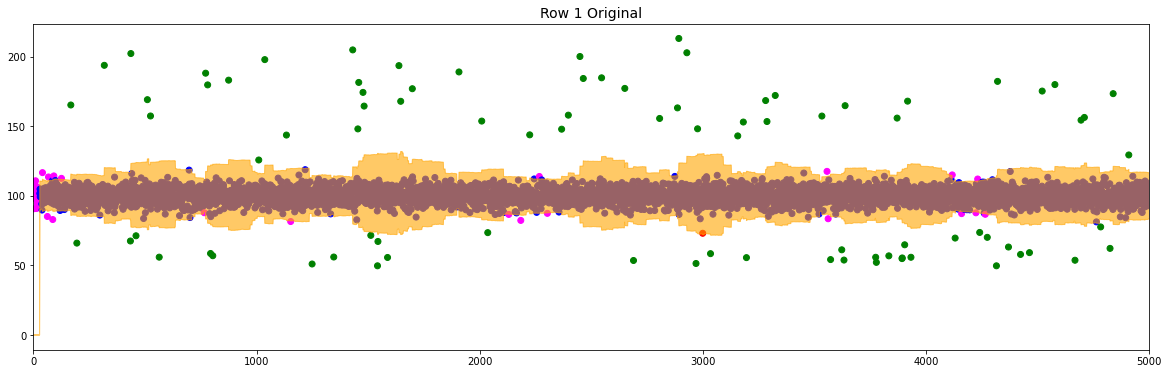

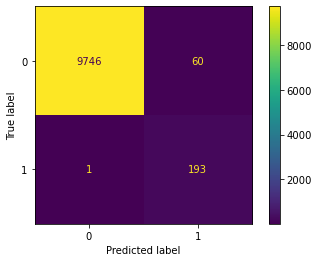

<Figure size 1440x432 with 0 Axes>

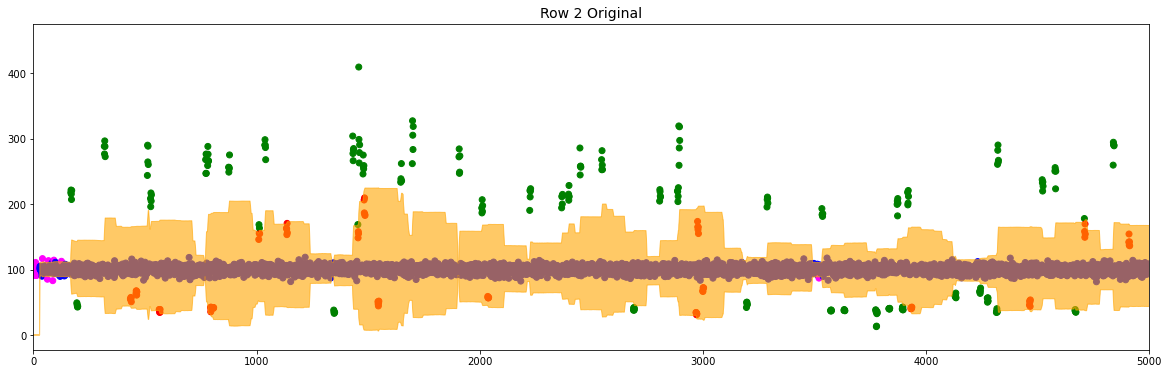

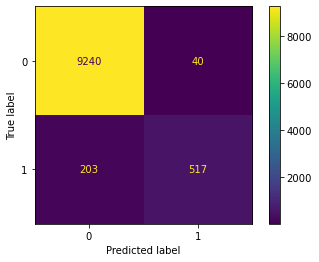

<Figure size 1440x432 with 0 Axes>

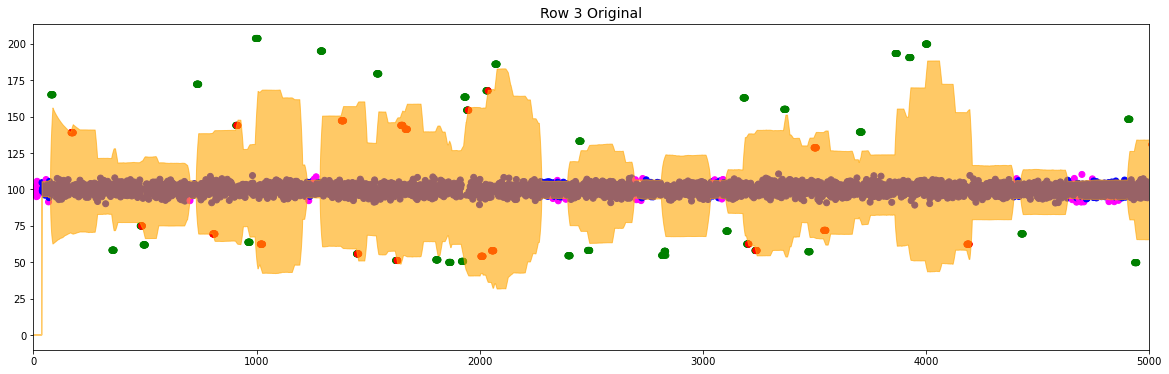

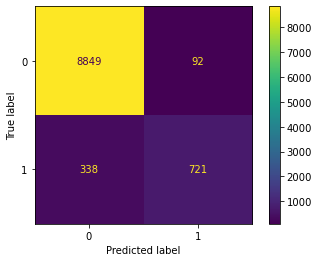

<Figure size 1440x432 with 0 Axes>

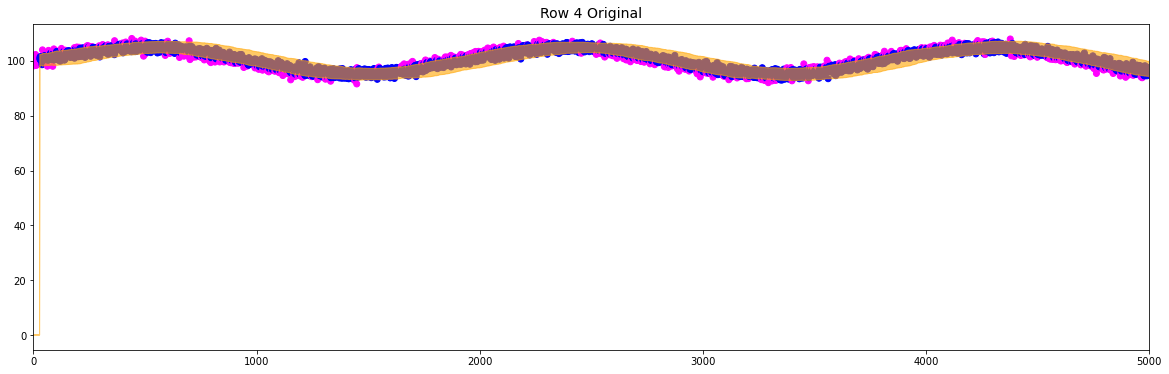

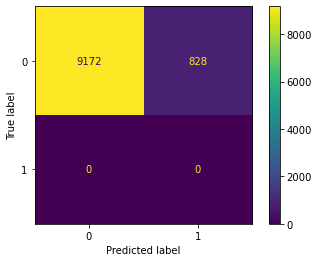

<Figure size 1440x432 with 0 Axes>

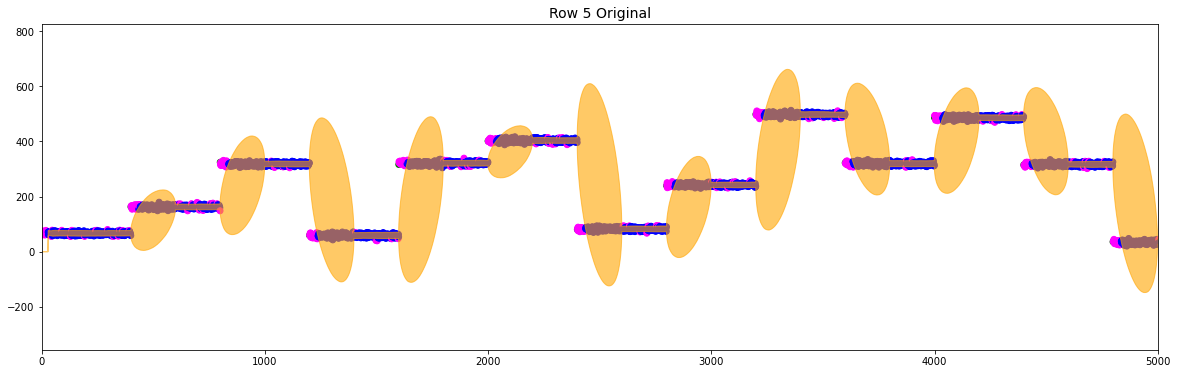

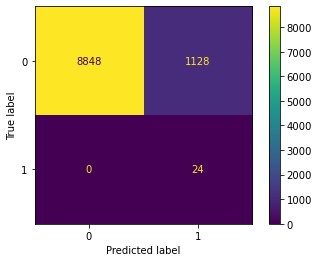

In [25]:
for i in range(1, 6):
    ma, b_lower, b_upper, y_pred = get_confidence_borders(df_outliers[f'row{i}'], window=200, p=0.98)
    colors = color_points(df_outliers[f'row{i}'].values, df_outliers[f'out_target{i}'].values, b_lower, b_upper)   
    plot_borders(df_outliers[f'row{i}'], df_outliers[f'out_target{i}'], 
                 ma, b_lower, b_upper, colors, start=0, stop=5000)
    plt.title(f'Row {i} Original', size=14)
    ConfusionMatrixDisplay(confusion_matrix(df_outliers[f'out_target{i}'], y_pred)).plot()
    
#     ma, b_lower, b_upper, _ = get_confidence_borders(df_outliers[f'row{i}'].diff(), window=200, p=0.98)
#     colors = color_points(df_outliers[f'row{i}'].diff().values, df_outliers[f'out_target{i}'].values, b_lower, b_upper)   
#     plot_borders(df_outliers[f'row{i}'].diff(), df_outliers[f'out_target{i}'], 
#                  ma, b_lower, b_upper, colors, start=0, stop=5000)
#     plt.title(f'Row {i} Diff')


___

## Фильтрация по "box_plot"

In [26]:
def get_box_borders(row, window=100, sigma=2):
    x = row.copy()
    x_roll = x.rolling(window, min_periods=30)
    meda = x_roll.median().fillna(0)
    q_25 = x_roll.quantile(0.25)
    q_75 = x_roll.quantile(0.75)
    range_ = q_75 - q_25
    b_lower = meda - sigma * range_
    b_upper = meda + sigma * range_
    y_pred = (x < b_lower) | (x > b_upper)
    return ma, b_lower, b_upper, y_pred

### Фильтрация абсолютных значений

- Низкое качество на "пороговых переходах"
- Отлично работает для остальных случаев

<Figure size 1440x432 with 0 Axes>

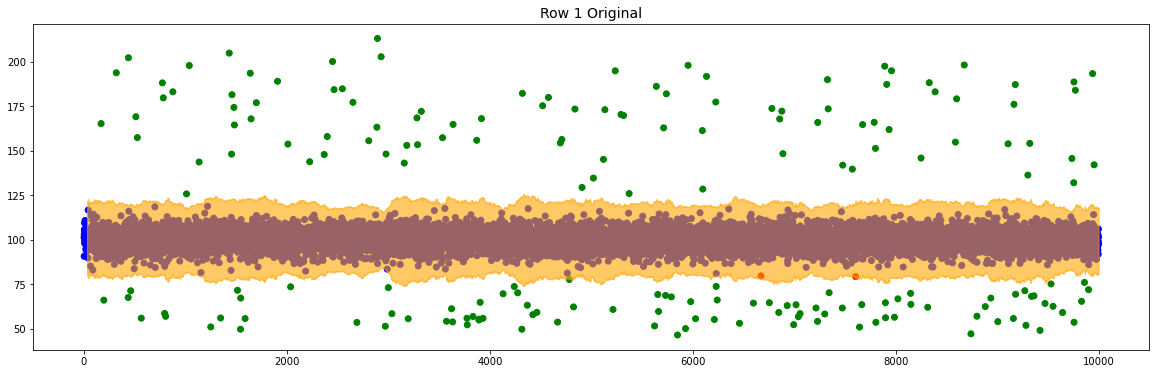

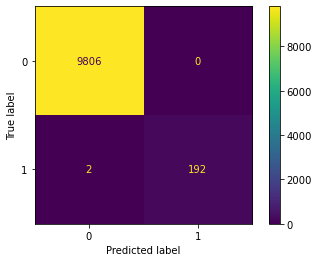

precision 1.0
recall 0.9896907216494846
f1 0.9948186528497409


<Figure size 1440x432 with 0 Axes>

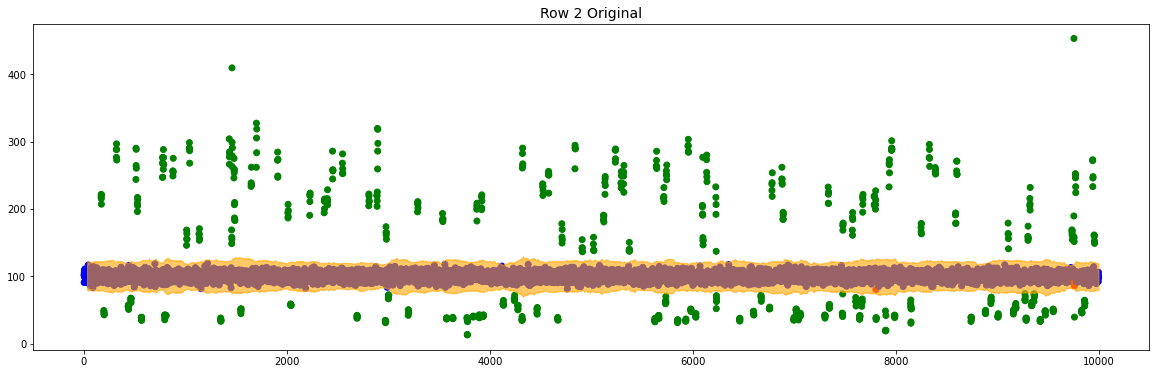

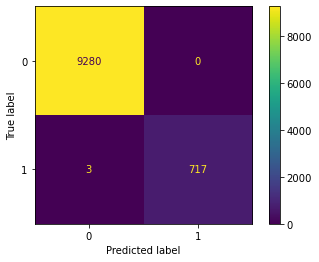

precision 1.0
recall 0.9958333333333333
f1 0.9979123173277662


<Figure size 1440x432 with 0 Axes>

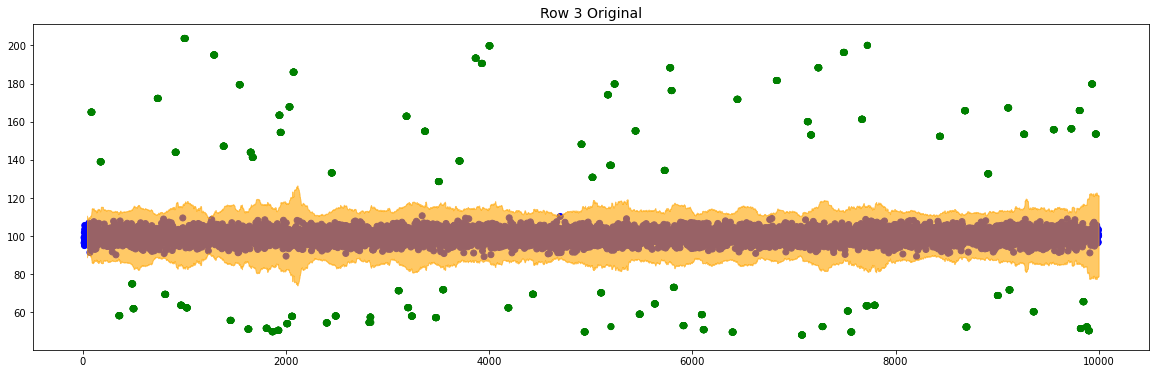

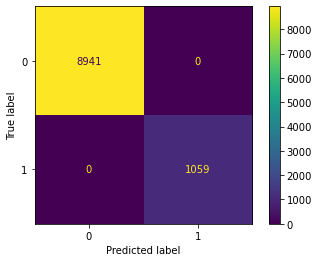

precision 1.0
recall 1.0
f1 1.0


<Figure size 1440x432 with 0 Axes>

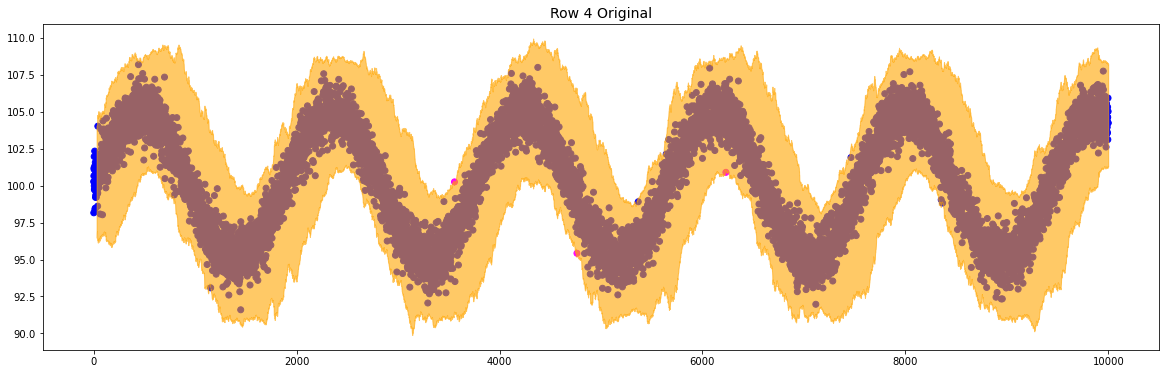

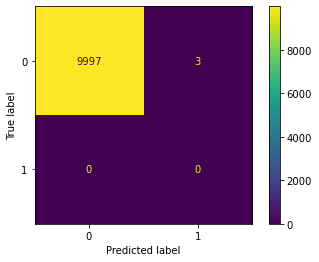

precision 0.0
recall 0.0
f1 0.0


D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x432 with 0 Axes>

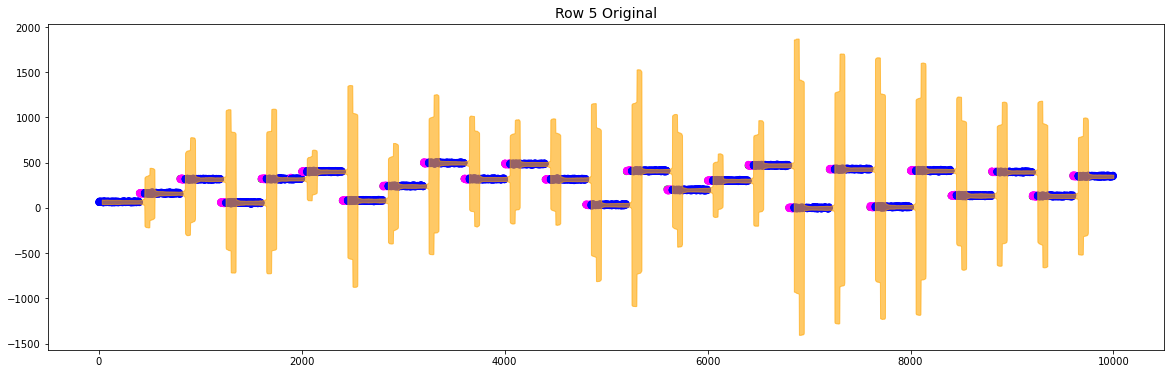

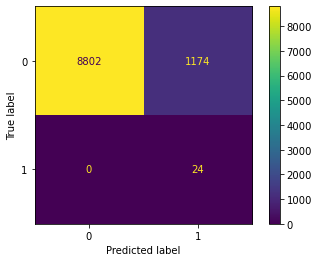

precision 0.02003338898163606
recall 1.0
f1 0.03927986906710311


In [27]:
for i in range(1, 6):
    ma, b_lower, b_upper, y_pred = get_box_borders(df_outliers[f'row{i}'], window=200, sigma=3)
    colors = color_points(df_outliers[f'row{i}'].values, df_outliers[f'out_target{i}'].values, b_lower, b_upper)   
    plot_borders(df_outliers[f'row{i}'], df_outliers[f'out_target{i}'], 
                 ma, b_lower, b_upper, colors=colors)
    plt.title(f'Row {i} Original', size=14)
    ConfusionMatrixDisplay(confusion_matrix( df_outliers[f'out_target{i}'], y_pred)).plot()
    plt.show()
    compute_metrics(df_outliers[f'out_target{i}'], y_pred)
    

### Фильтрация по diff


- Идеально работает на "пороговых переходах"
- Хуже работает в остальных случаях

<Figure size 1440x432 with 0 Axes>

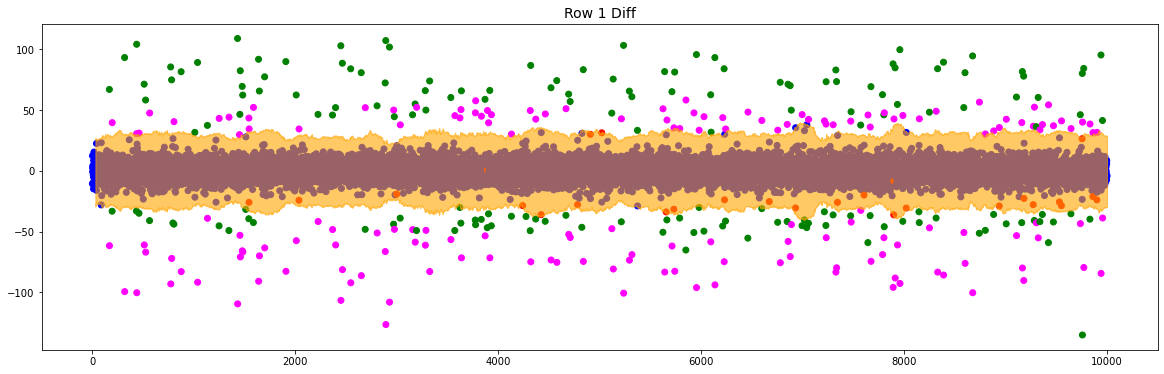

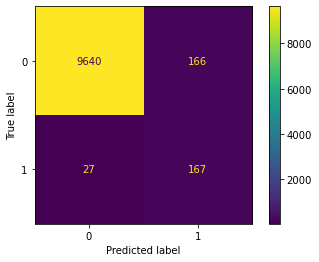

precision 0.5015015015015015
recall 0.8608247422680413
f1 0.6337760910815939


<Figure size 1440x432 with 0 Axes>

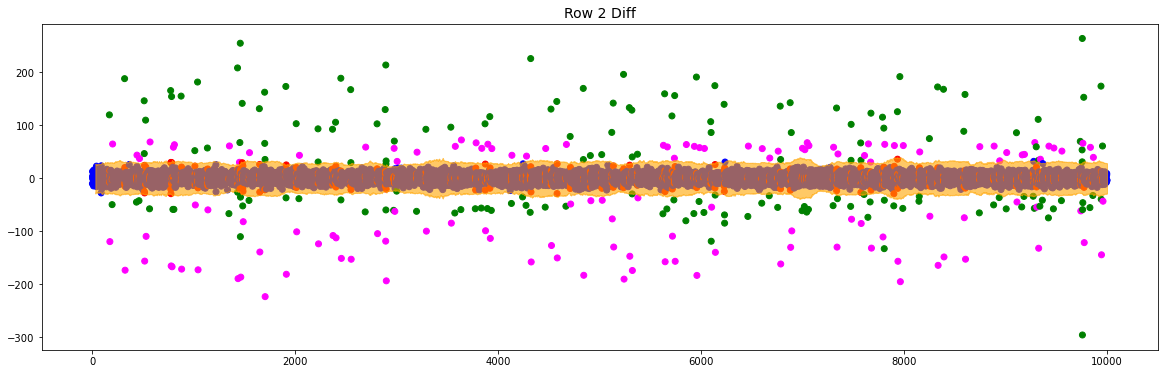

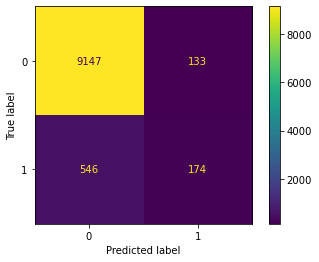

precision 0.5667752442996743
recall 0.24166666666666667
f1 0.3388510223953262


<Figure size 1440x432 with 0 Axes>

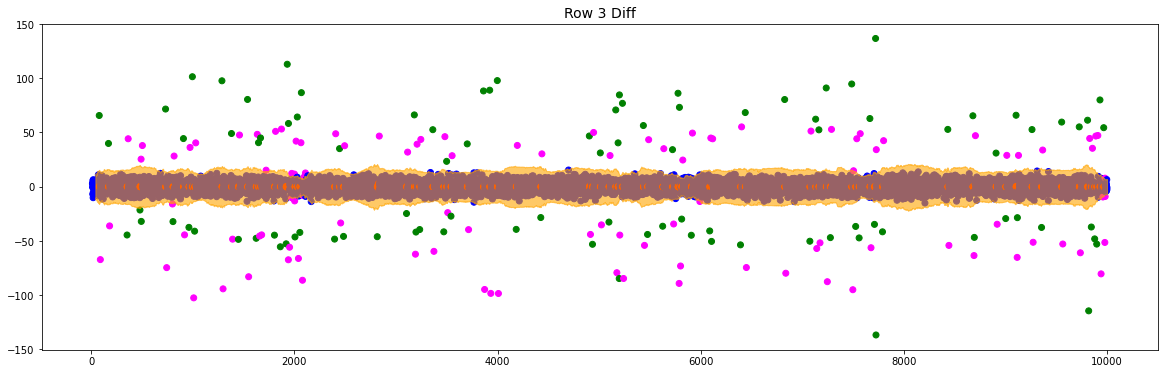

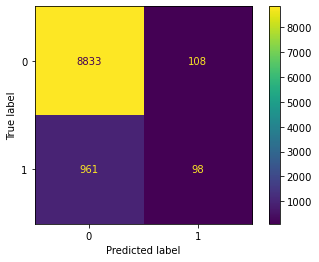

precision 0.47572815533980584
recall 0.09254013220018886
f1 0.1549407114624506


<Figure size 1440x432 with 0 Axes>

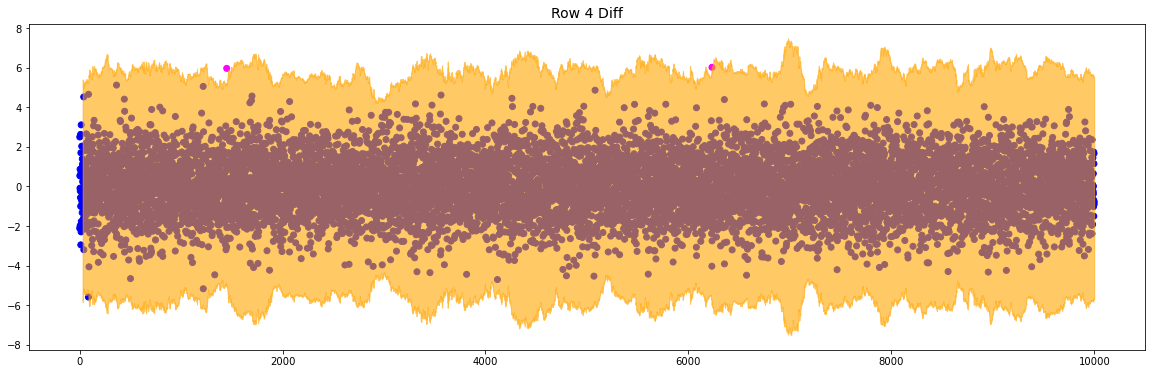

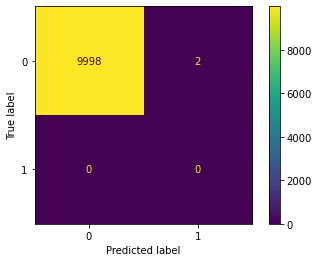

precision 0.0
recall 0.0
f1 0.0


D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 1440x432 with 0 Axes>

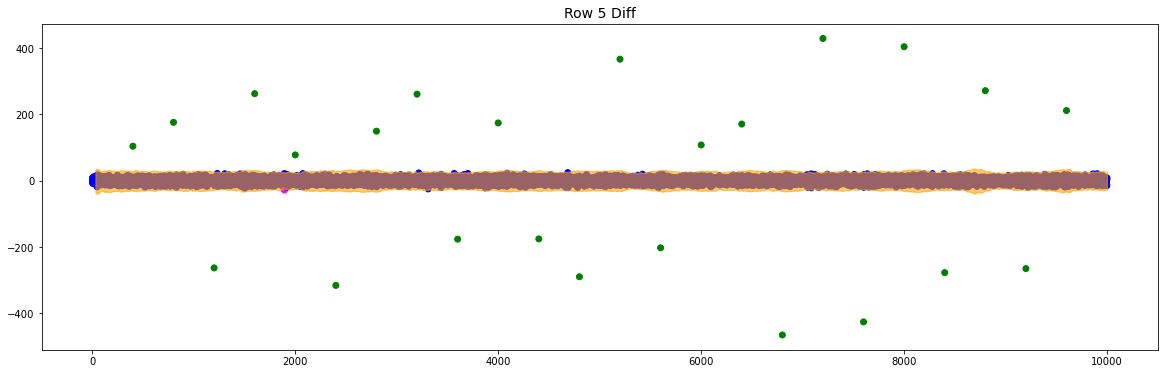

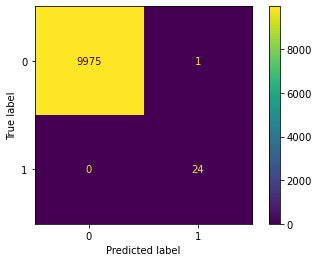

precision 0.96
recall 1.0
f1 0.9795918367346939


In [28]:
for i in range(1, 6):
    ma, b_lower, b_upper, y_pred = get_box_borders(df_outliers[f'row{i}'].diff(), window=200, sigma=3)
    colors = color_points(df_outliers[f'row{i}'].diff().values, df_outliers[f'out_target{i}'].values, b_lower, b_upper)
    plot_borders(df_outliers[f'row{i}'].diff(), df_outliers[f'out_target{i}'], 
                 ma, b_lower, b_upper, colors=colors)
    plt.title(f'Row {i} Diff', size=14)
    ConfusionMatrixDisplay(confusion_matrix( df_outliers[f'out_target{i}'], y_pred)).plot()
    plt.show()
    compute_metrics(df_outliers[f'out_target{i}'], y_pred)
    

### Комбинация box-filtering на абсолютах и диффах

- Оптимальный вариант на синтетических данных

<Figure size 1440x432 with 0 Axes>

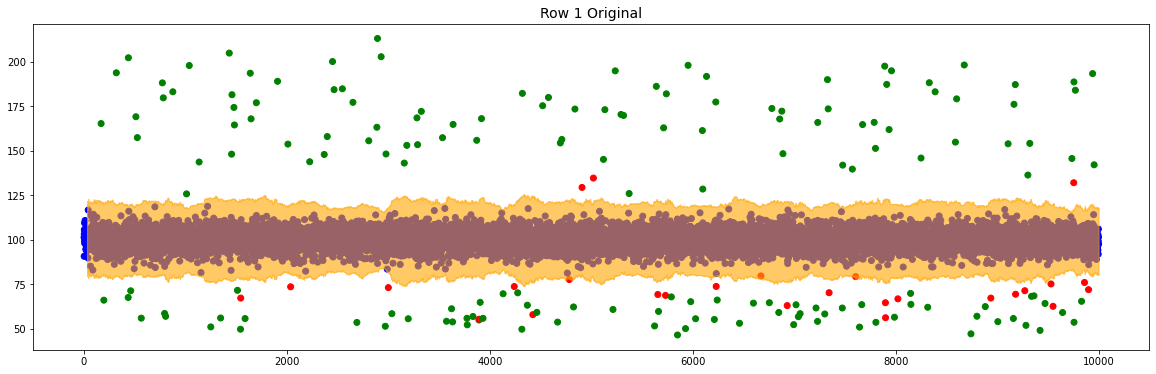

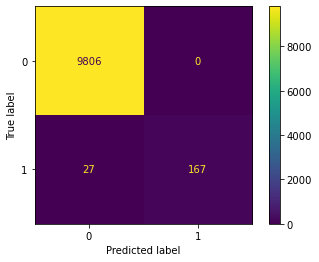

precision 1.0
recall 0.8608247422680413
f1 0.925207756232687


<Figure size 1440x432 with 0 Axes>

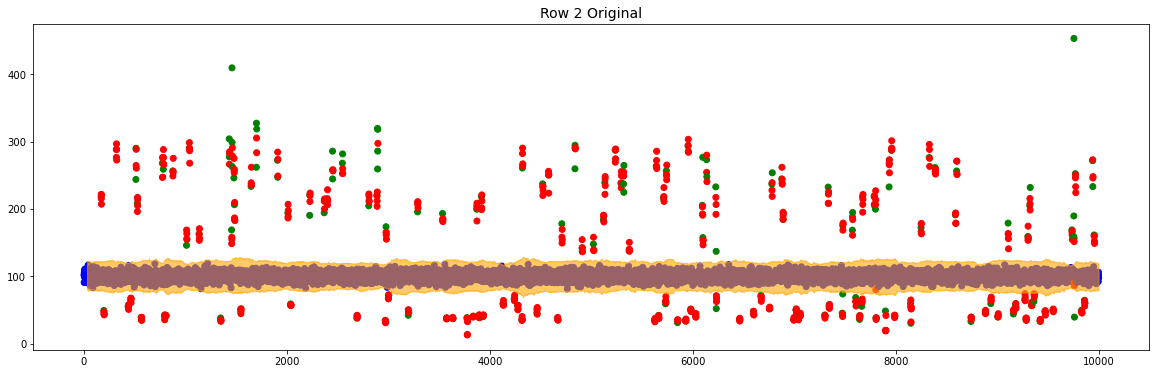

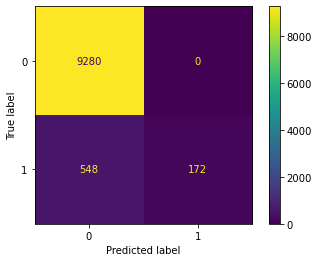

precision 1.0
recall 0.2388888888888889
f1 0.38565022421524664


<Figure size 1440x432 with 0 Axes>

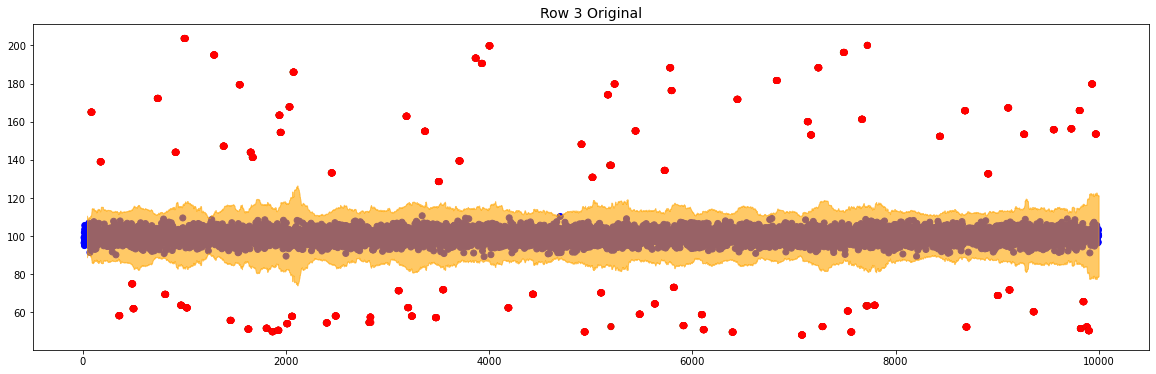

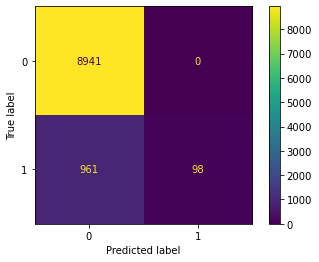

precision 1.0
recall 0.09254013220018886
f1 0.1694036300777874


<Figure size 1440x432 with 0 Axes>

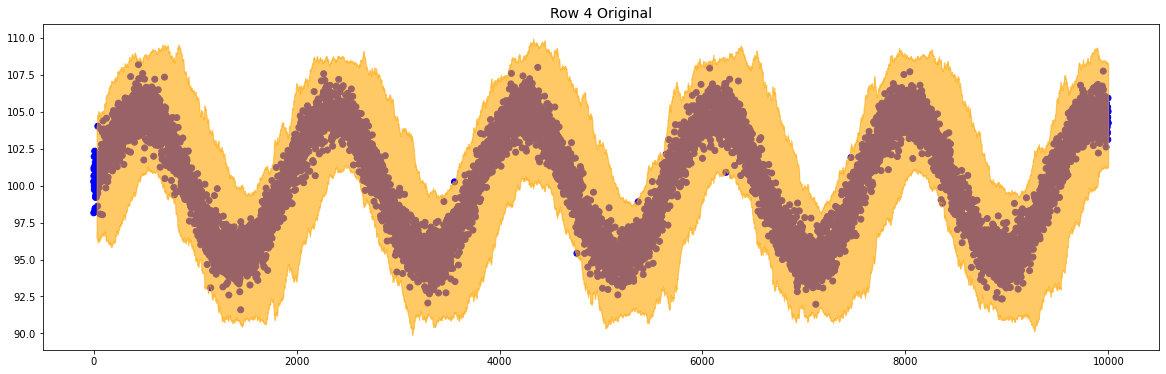

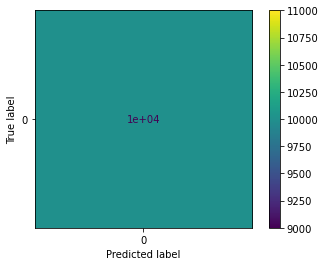

D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1495: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(


precision 0.0
recall 0.0
f1 0.0


<Figure size 1440x432 with 0 Axes>

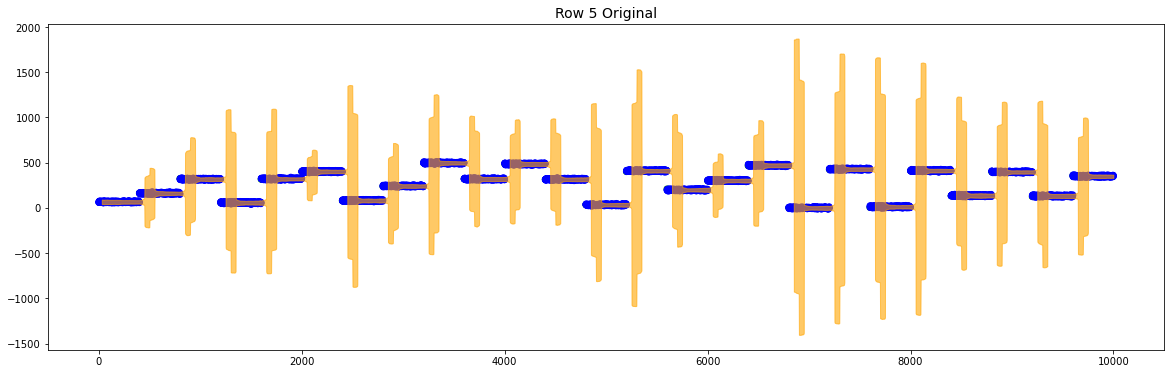

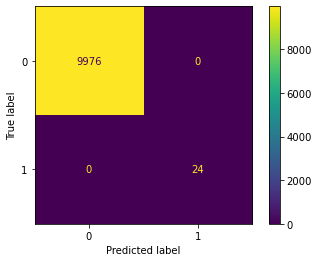

precision 1.0
recall 1.0
f1 1.0


In [29]:
for i in range(1, 6):
    ma, b_lower, b_upper, y_pred = get_box_borders(df_outliers[f'row{i}'], window=200, sigma=3)
    ma_diff, b_lower_diff, b_upper_diff, y_pred_diff = get_box_borders(df_outliers[f'row{i}'].diff(), window=200, sigma=3)
    y_pred = y_pred & y_pred_diff
    
    colors = color_points_binary(df_outliers[f'out_target{i}'].values, y_pred)   
    plot_borders(df_outliers[f'row{i}'], df_outliers[f'out_target{i}'], 
                 ma, b_lower, b_upper, colors=colors)
    plt.title(f'Row {i} Original', size=14)
    ConfusionMatrixDisplay(confusion_matrix( df_outliers[f'out_target{i}'], y_pred)).plot()
    plt.show()
    compute_metrics(df_outliers[f'out_target{i}'], y_pred)